# Which city needs more coffee? 
## An exploration of data related to coffee consumption, market saturation, and potential market size between Vancouver, Washington and Bellingham, Washington.
### Tyler Waite's IBM Certificate in Data Science Capstone Project Notebook 
### April 16, 2020

## Introduction

**Audience:**

For the purpose of this notebook the "audience" is a client who is looking to purchase a coffee franchise in the state of Washington. They are looking to invest in a mid-size city that is not as saturated with existing coffee shops. Vancouver and Bellingham Washington have been proposed as possible locations.  The client needs data on how saturated the coffee market is in these two cities and what brands are the most popular and most common in these cities.

**Method**

This notebook will do some basic data exploration of cities and regions that are rated as having great coffee.  It will illustrate how to use screen scraping to get latitude and longitude data from a Wikipedia page for the two cities.  It will show how to use geopy geolocator to get the latitude and longitude for the two cities. The latitude and longitude data will be passed to Folium rendering library to generate a map of the two cities.  The latitude and longitude data will also be passed to Foursquare to determine how many coffee shops are located in Vancouver and Bellingham.  In addition there will be a comparison of the population sizes of the two cities to determine which one has a larger potential market.  

Note: The analysis is limited to the brands that are available as venues in Foursquare.  The only national brands listed in Foursquare are Starbucks, Tim Hortons, Caribou Coffee, Coffee Bean & Tea Leaf, Dunkin Coffee & Dunkin Donuts, and Peet's Coffee & Tea.  I tried searching for other national brands such as Tully's and Dutch Brothers on the Foursquare site, but they did not return any matches.  


## Import Libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library


print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-1.21.0               |             py_0          58 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          92 KB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-1.21.0-py_0



geopy-1.21.0         | 58 KB     | ##################################### | 100% 
geographiclib-1.50   | 34 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done
Sol

In [2]:
#Install Web Parsing libraries to pull city demographic data.
!pip install beautifulsoup4
!pip install lxml
!pip install html5lib 
!pip install requests
print('Beautiful Soup, lxml, html5lib, and requests are installed.')

     |████████████████████████████████| 112kB 6.9MB/s eta 0:00:01
     |████████████████████████████████| 5.8MB 7.7MB/s eta 0:00:01
Beautiful Soup, lxml, html5lib, and requests are installed.


## Data - Which regions have the most cities in the top 100 "Best Cities for Coffee Lovers"?

In [18]:
#Data is from Wallethub http://wallethub.com/edu/best-cities-for-coffee-lovers/23739/, CSV import pattern is from https://datatofish.com/import-csv-file-python-using-pandas/
coffee_rank_df = pd.read_csv (r'Coffee_Cities_Ranking.csv')   #read the csv file (put 'r' before the path string to address any special characters in the path, such as '\'). Don't forget to put the file name at the end of the path + ".csv"
print (coffee_rank_df)

    Rank                   City State        Region  Score
0      1            Seattle, WA    WA    North West  69.44
1      2           New York, NY    NY  Mid Atlantic  67.42
2      3      San Francisco, CA    CA          West  65.31
3      4           Portland, OR    OR    North West  64.88
4      5        Los Angeles, CA    CA          West  60.23
5      6            Chicago, IL    IL      Mid West  57.09
6      7         Washington, DC    DC  Mid Atlantic  54.26
7      8              Miami, FL    FL    South East  53.60
8      9          San Diego, CA    CA          West  51.04
9     10             Boston, MA    MA    North East  48.61
10    11       Philadelphia, PA    PA  Mid Atlantic  47.31
11    12            Atlanta, GA    GA    South East  47.31
12    13             Denver, CO    CO    South West  47.20
13    14          Las Vegas, NV    NV          West  46.93
14    15            Orlando, FL    FL    South East  45.87
15    16        Minneapolis, MN    MN      Mid West  44.

In [49]:
#Which region has the most cities in the list of top 100 coffee cities?
region_city_count_df=coffee_rank_df['Region'].value_counts()
region_city_count_df

South West      26
West            21
South East      18
Mid West        18
Mid Atlantic    11
North West       3
Pacific          2
North East       1
Name: Region, dtype: int64

Given the North West's reputation as a coffee lover region, it is surprising that there are only 3 cities that make the list.

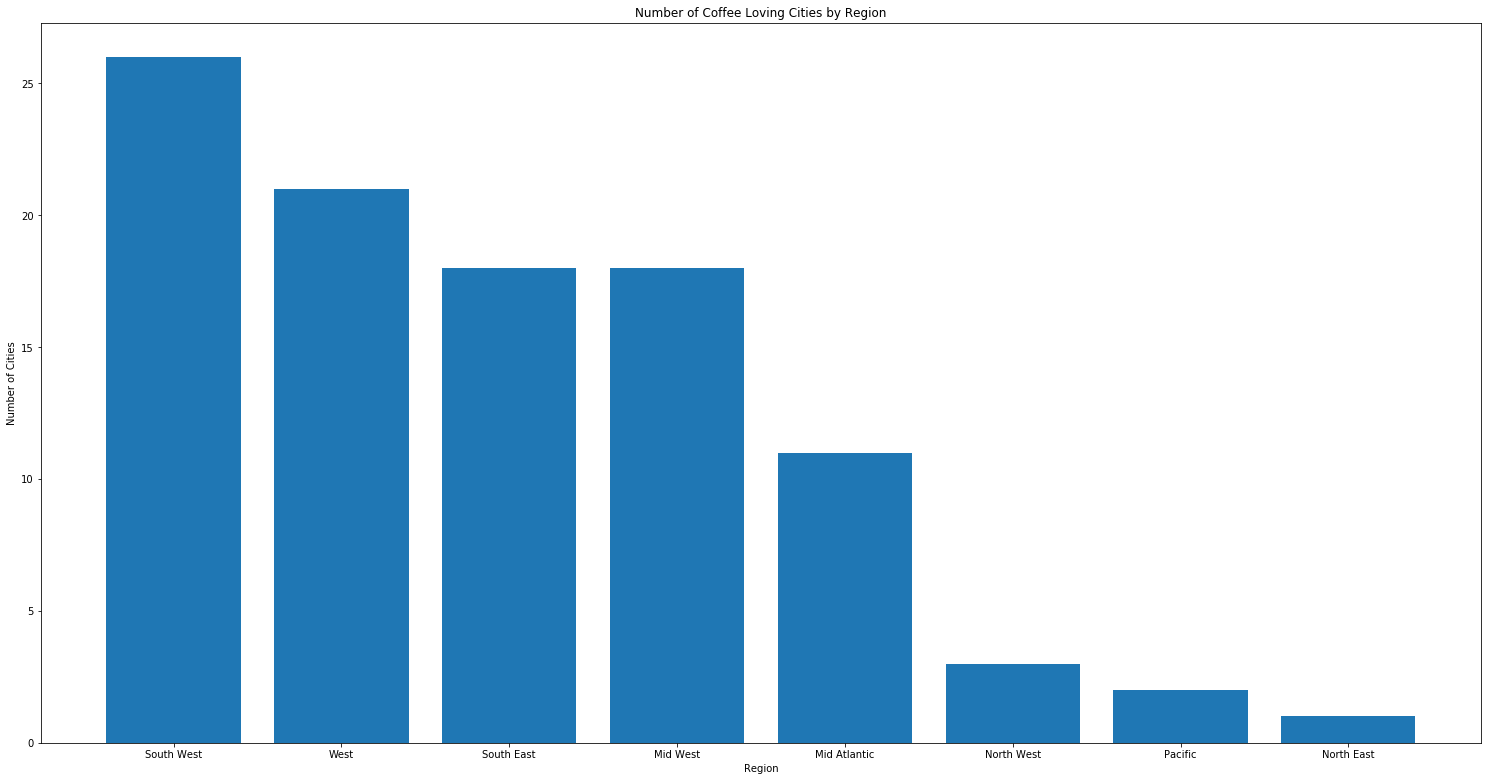

In [99]:
# Pie chart of the regional counts from example found at https://www.tutorialspoint.com/matplotlib/matplotlib_bar_plot.htm
fig = plt.figure(figsize=(20,10))
ax = fig.add_axes([0,0,1,1])

Regions = ['South West', 'West', 'South East', 'Mid West', 'Mid Atlantic', 'North West', 'Pacific', 'North East']
Cities = [26, 21, 18, 18, 11, 3, 2, 1]
ax.bar(Regions,Cities)
ax.set_ylabel('Number of Cities')
ax.set_xlabel('Region')
ax.set_title('Number of Coffee Loving Cities by Region')
plt.show()

In [38]:
#Find the average score by region.
av_rank_score_by_region_df=coffee_rank_df.groupby('Region').mean().sort_values(by='Score', ascending=False)
av_rank_score_by_region_df

,Rank,Score
Region,,
North West,12.666667,57.036667
North East,10.000000,48.610000
Mid Atlantic,38.000000,39.505455
West,47.142857,36.243810
Pacific,41.500000,36.195000
South West,53.769231,31.932308
South East,59.555556,31.591667
Mid West,57.833333,31.074444


Given how few cities from the North West were included on the list (3), the average score of 57.036667 shows that the North West deserves it reputation for loving coffee.  The lack of more cities on the list could indicate that the North West region could support more growth in other cities in the region.

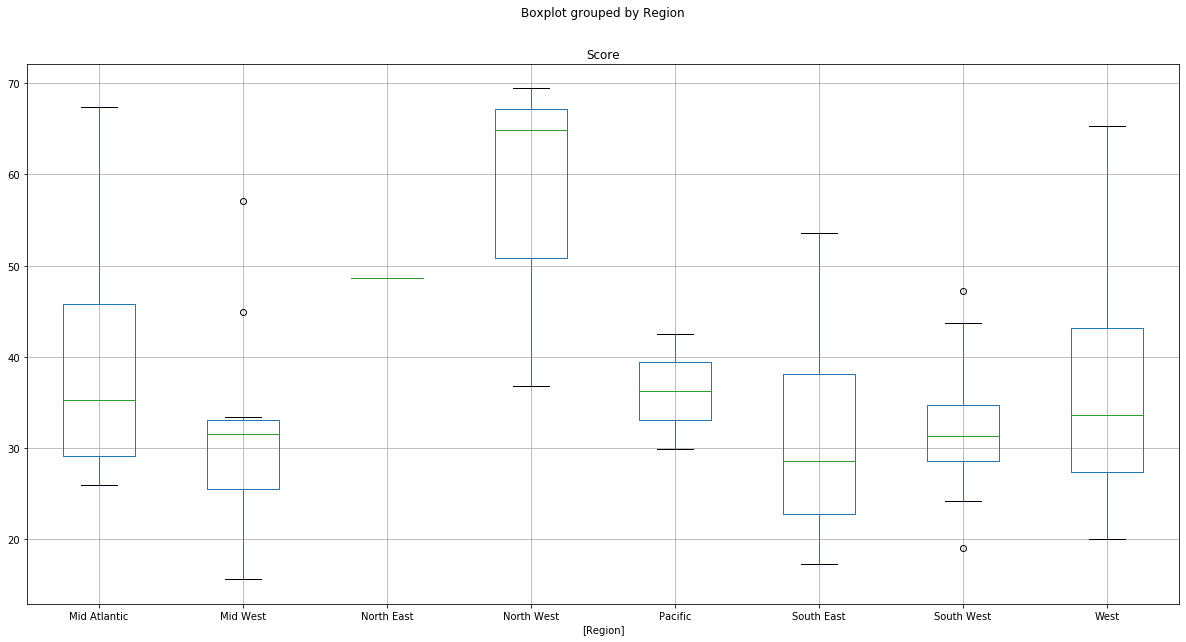

In [41]:
#box plot of the average city score by region.  
#Boxplot pattern found here: https://www.pythonprogramming.in/boxplot-group-by-column-data.html
#Figsize example found at https://www.drawingfromdata.com/setting-figure-size-using-seaborn-and-matplotlib
coffee_rank_df.boxplot(column=['Score'], by=['Region'], figsize=(20,10))
plt.show()

This box plot of the city scores by region paints a clear picture that the cities in the North West are at the top of the heap.

## Data - Get Lat Long and Population information for the cities

### Getting the the latitude and longitude is by scraping the information from the Wikipedia page for the city.

I initially tried to get the lat long data by scraping the Wikipedia page for the cities.

In [56]:
#import Vancouver, WA Wikipedia page into a format that can be searched with BeautifulSoup
import urllib.request
vancouver_url = "https://en.wikipedia.org/wiki/Vancouver%2C_Washington"
vancouver_page = urllib.request.urlopen(vancouver_url)
from bs4 import BeautifulSoup
v_soup = BeautifulSoup(vancouver_page, "lxml")
#print(v_soup.prettify()) #uncomment to view screen scrapped html

In [51]:
#finds the first occurence of the latitude class.
vancouver_lat= v_soup.find('span', attrs={"class":"latitude"})
vancouver_lat

<span class="latitude">45°38′N</span>

In [6]:
#finds the first occurence of the longitude class.
vancouver_long= v_soup.find('span', attrs={"class":"longitude"})
vancouver_long

<span class="longitude">122°36′W</span>

In [8]:
#import Vancouver, WA Wikipedia page into a format that can be searched with BeautifulSoup
import urllib.request
bellingham_url = "https://en.wikipedia.org/wiki/Bellingham,_Washington"
bellingham_page = urllib.request.urlopen(bellingham_url)
from bs4 import BeautifulSoup
b_soup = BeautifulSoup(bellingham_page, "lxml")
#print(b_soup.prettify()) #uncomment to view screen scrapped html

In [9]:
#finds the first occurence of the latitude class.
bellingham_lat= b_soup.find('span', attrs={"class":"latitude"})
bellingham_lat

<span class="latitude">48°45′1″N</span>

In [10]:
#finds the first occurence of the longitude class.
bellingham_long= b_soup.find('span', attrs={"class":"longitude"})
bellingham_long

<span class="longitude">122°28′30″W</span>

In [11]:
#writes lat long values to a df.
lat_long_df = pd.DataFrame({'City':['Vancover','Bellingham'],'Latitude': [vancouver_lat, bellingham_lat], 'Longitude': [vancouver_long, bellingham_long]})
lat_long_df

,City,Latitude,Longitude
0,Vancover,[45°38′N],[122°36′W]
1,Bellingham,[48°45′1″N],[122°28′30″W]


In [12]:
#removing brackets from lat long values
b_lat = str(bellingham_lat)[23:-7] 
b_long = str(bellingham_long)[24:-7] 
v_lat = str(vancouver_lat)[23:-7] 
v_long = str(vancouver_long)[24:-7] 

new_lat_long_df = pd.DataFrame({'City':['Vancover','Bellingham'],'Latitude': [v_lat, b_lat], 'Longitude': [v_long, b_long]})
new_lat_long_df

,City,Latitude,Longitude
0,Vancover,45°38′N,122°36′W
1,Bellingham,48°45′1″N,122°28′30″W


These are the right coordinates, but they are not in the correct format for using with Foursquare data.

### Another way that we can find the latitude and longitude of a city is with geolocator.

In [75]:
#finding the lat long of Vancouver, WA
address = 'Vancouver, WA'

geolocator = Nominatim(user_agent="vancouver_explorer")
location = geolocator.geocode(address)
v_latitude = location.latitude
v_longitude = location.longitude
print('The geograpical coordinate of Vancouver, WA are {}, {}.'.format(v_latitude, v_longitude))

The geograpical coordinate of Vancouver, WA are 45.6306954, -122.6744557.


In [76]:
#finding the lat long of Bellingham, WA
address = 'Bellingham, WA'

geolocator = Nominatim(user_agent="bellingham_explorer")
location = geolocator.geocode(address)
b_latitude = location.latitude
b_longitude = location.longitude
print('The geograpical coordinate of Bellingham, WA are {}, {}.'.format(b_latitude, b_longitude))

The geograpical coordinate of Bellingham, WA are 48.7544012, -122.4788361.


### We can use the folium library to create a map using the latitude and longitude in order to make sure they are for the right city.

In [77]:
# create map of Vancouver, WA using latitude and longitude values
map_vancouver = folium.Map(location=[v_latitude, v_longitude], zoom_start=12) 
map_vancouver

In [78]:
# create map of Bellingham, WA using latitude and longitude values
map_bellingham = folium.Map(location=[b_latitude, b_longitude], zoom_start=12) 
map_bellingham

The maps verified that we have the correct coordinates.

## Getting Vancouver, WA Coffee Shops

Now that I have the coordinates for the cities that I am interested in, I can use Foursquare to retrieve a list of coffee shops in those cities.

In [80]:
#Foursquare requires a Client ID and a Client Secret to access their venue data.  I removed my Client ID and Client Secret after creating this report for security reasons.
CLIENT_ID = 'S2HKIY0I0AZ20OL4M0MU3105W2LUBPHQOHP3R0CIPCVTXNSK' # my Foursquare ID
CLIENT_SECRET = 'NPKIMKVQZ4OGTW1VIIKBX4I3RQ4CLRG3FV41DKDBGZX0GQWB' # my Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [81]:
#Getting the top 500 venues for Vancouver, WA
LIMIT = 500 # limit of number of venues returned by Foursquare API
radius = 1000 # define radius

# create URL
v_url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    v_latitude, 
    v_longitude, 
    radius, 
    LIMIT)
v_url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=S2HKIY0I0AZ20OL4M0MU3105W2LUBPHQOHP3R0CIPCVTXNSK&client_secret=NPKIMKVQZ4OGTW1VIIKBX4I3RQ4CLRG3FV41DKDBGZX0GQWB&v=20180605&ll=45.6306954,-122.6744557&radius=1000&limit=500'

In [82]:
#getting the Vancouver WA venue json file
v_results = requests.get(v_url).json()
#v_results #uncomment this if you want to view the json file.

In [84]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [85]:
#getting the venue names, categories, and lat long from the json file.

vancouver_venues = v_results['response']['groups'][0]['items']
    
vancouver_venues = pd.json_normalize(vancouver_venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories','venue.location.lat', 'venue.location.lng']
vancouver_venues =vancouver_venues.loc[:, filtered_columns]

# filter the category for each row
vancouver_venues['venue.categories'] = vancouver_venues.apply(get_category_type, axis=1)

# clean columns
vancouver_venues.columns = [col.split(".")[-1] for col in vancouver_venues.columns]

vancouver_venues.head()

,name,categories,lat,lng
0,Treat,Cupcake Shop,45.628998,-122.673591
1,Java House,Coffee Shop,45.628922,-122.673578
2,Kiggins Theatre,Movie Theater,45.629210,-122.671433
3,Thai Orchid,Thai Restaurant,45.629265,-122.673397
4,Compass Coffee,Financial or Legal Service,45.627938,-122.672554


In [86]:
#Removing all venues that are not Coffee Shops
vancouver_coffee_venues = vancouver_venues.loc[vancouver_venues['categories'] == 'Coffee Shop']
vancouver_coffee_venues

,name,categories,lat,lng
1,Java House,Coffee Shop,45.628922,-122.673578
8,Compass Coffee,Coffee Shop,45.631346,-122.671669
31,Relevant Coffee,Coffee Shop,45.634258,-122.671342
38,Black Rock Coffee Bar,Coffee Shop,45.628872,-122.670197
48,Mon Ami,Coffee Shop,45.635922,-122.671667
59,Starbucks,Coffee Shop,45.627355,-122.674356
61,Starbucks,Coffee Shop,45.639399,-122.671596


In [87]:
# Reseting the row index to 0-6.
vancouver_coffee_venues.reset_index(drop=True)

,name,categories,lat,lng
0,Java House,Coffee Shop,45.628922,-122.673578
1,Compass Coffee,Coffee Shop,45.631346,-122.671669
2,Relevant Coffee,Coffee Shop,45.634258,-122.671342
3,Black Rock Coffee Bar,Coffee Shop,45.628872,-122.670197
4,Mon Ami,Coffee Shop,45.635922,-122.671667
5,Starbucks,Coffee Shop,45.627355,-122.674356
6,Starbucks,Coffee Shop,45.639399,-122.671596


## Getting Bellingham Coffe Shop Data

In [88]:
# Getting the top 500 venues for Bellingham, WA
LIMIT = 500 # limit of number of venues returned by Foursquare API
radius = 1000 # define radius

# create URL
b_url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    b_latitude, 
    b_longitude, 
    radius, 
    LIMIT)
b_url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=S2HKIY0I0AZ20OL4M0MU3105W2LUBPHQOHP3R0CIPCVTXNSK&client_secret=NPKIMKVQZ4OGTW1VIIKBX4I3RQ4CLRG3FV41DKDBGZX0GQWB&v=20180605&ll=48.7544012,-122.4788361&radius=1000&limit=500'

In [89]:
#getting the Vancouver WA venue json file
b_results = requests.get(b_url).json()
#b_results

In [90]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [91]:
#getting the venue names, categories, and lat long from the json file.

bellingham_venues = b_results['response']['groups'][0]['items']
    
bellingham_venues = pd.json_normalize(bellingham_venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
bellingham_venues =bellingham_venues.loc[:, filtered_columns]

# filter the category for each row
bellingham_venues['venue.categories'] = bellingham_venues.apply(get_category_type, axis=1)

# clean columns
bellingham_venues.columns = [col.split(".")[-1] for col in bellingham_venues.columns]

bellingham_venues.head()

,name,categories,lat,lng
0,Mount Baker Theatre,Performing Arts Venue,48.752418,-122.477757
1,The Black Drop Coffeehouse,Coffee Shop,48.751879,-122.479771
2,Wander Brewing,Brewery,48.754287,-122.473947
3,Ciao Thyme,Café,48.753167,-122.476879
4,Bellingham Public Library,Bookstore,48.754580,-122.478853


In [92]:
#Removing all venues that are not Coffee Shops
bellingham_coffee_venues = bellingham_venues.loc[bellingham_venues['categories'] == 'Coffee Shop']
bellingham_coffee_venues

,name,categories,lat,lng
1,The Black Drop Coffeehouse,Coffee Shop,48.751879,-122.479771
12,Camber,Coffee Shop,48.751016,-122.481185
36,Starbucks,Coffee Shop,48.749112,-122.478459
46,The Woods Coffee on Railroad and Chestnut,Coffee Shop,48.748085,-122.479707
58,Lettered Streets Coffeehouse,Coffee Shop,48.757264,-122.484722
69,Cool Beans Coffee,Coffee Shop,48.754616,-122.476133
74,Underground Coffee House,Coffee Shop,48.760579,-122.485393
75,Spartan Espresso,Coffee Shop,48.754958,-122.466154


In [93]:
bellingham_coffee_venues.reset_index(drop=True)

,name,categories,lat,lng
0,The Black Drop Coffeehouse,Coffee Shop,48.751879,-122.479771
1,Camber,Coffee Shop,48.751016,-122.481185
2,Starbucks,Coffee Shop,48.749112,-122.478459
3,The Woods Coffee on Railroad and Chestnut,Coffee Shop,48.748085,-122.479707
4,Lettered Streets Coffeehouse,Coffee Shop,48.757264,-122.484722
5,Cool Beans Coffee,Coffee Shop,48.754616,-122.476133
6,Underground Coffee House,Coffee Shop,48.760579,-122.485393
7,Spartan Espresso,Coffee Shop,48.754958,-122.466154


#### Based on this data Foursquare has seven coffee shops for both Vancouver and Bellingham.

In [94]:
#Population and income data for the two cities taken from their Wikipedia pages.
cities_data = {'City':  ['Bellingham', 'Vancouver'],
        'Population-City': ['80885', '161791'],
        'Population-Metro': ['225685', '2478810'],       
        'Median Income':['46114','41618'],
        }
cities_df = pd.DataFrame (cities_data, columns = ['City','Population-City','Population-Metro','Median Income'])
cities_df

,City,Population-City,Population-Metro,Median Income
0,Bellingham,80885,225685,46114
1,Vancouver,161791,2478810,41618


## Results

### Mapping the Coffee Shops

We can add markers to the maps to see where the coffee shops are located.  This will help to identify if there are any under served neighborhoods.

In [95]:
# create map of Vancouver Coffee Shops using latitude and longitude values
map_vancouver = folium.Map(location=[v_latitude, v_longitude], zoom_start=15)

# add markers to map
for lat, lng, name, categories in zip(vancouver_coffee_venues['lat'], vancouver_coffee_venues['lng'], vancouver_coffee_venues['name'], vancouver_coffee_venues['categories']):
    label = '{}, {}'.format(name, categories)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_vancouver)  
    
map_vancouver

In [96]:
# create map of Bellingham Coffee Shops using latitude and longitude values
map_bellingham = folium.Map(location=[b_latitude, b_longitude], zoom_start=15)

# add markers to map
for lat, lng, name, categories in zip(bellingham_coffee_venues['lat'], bellingham_coffee_venues['lng'], bellingham_coffee_venues['name'], bellingham_coffee_venues['categories']):
    label = '{}, {}'.format(name, categories)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_bellingham)  
    
map_bellingham

### Population Comparison

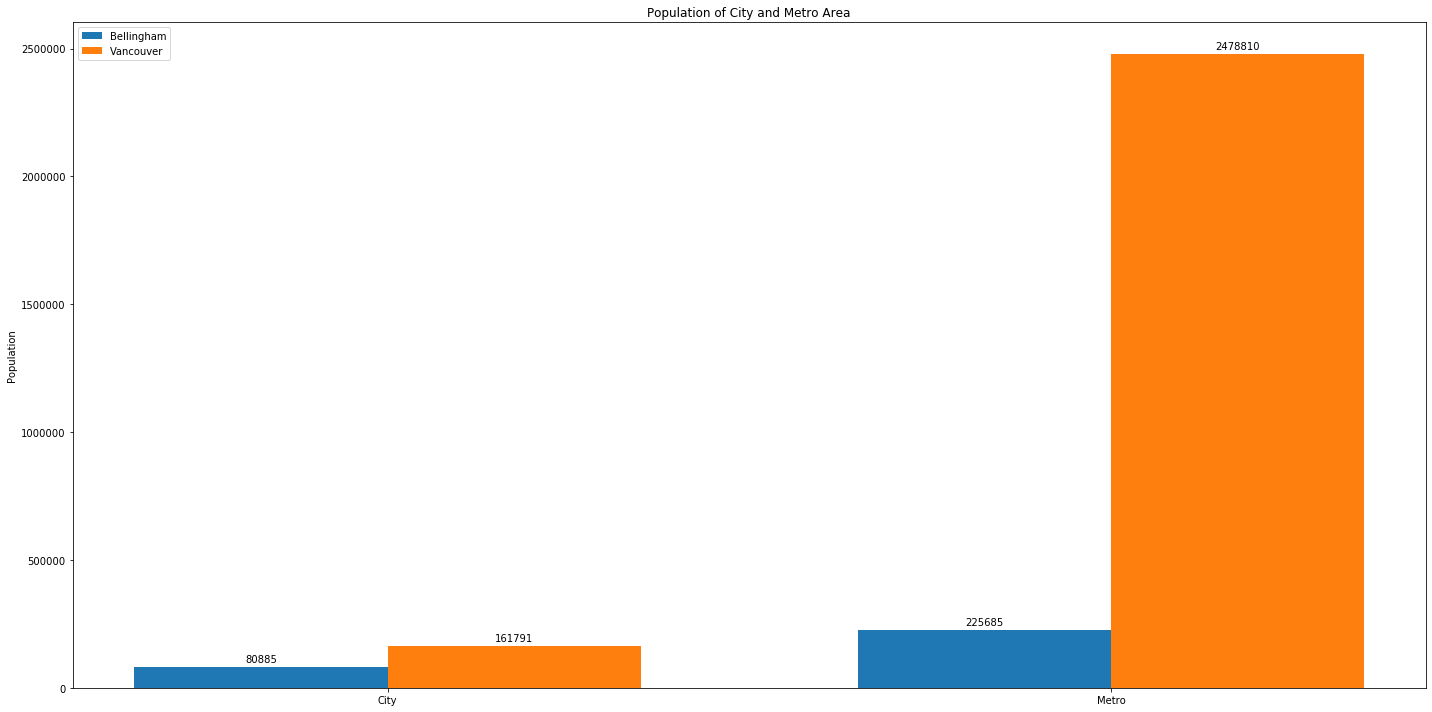

In [97]:
# Chart is based on example that can be found at https://matplotlib.org/3.2.1/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py

labels = ['City', 'Metro']
Bellingham = [80885, 225685]
Vancouver = [161791, 2478810]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(20,10))
rects1 = ax.bar(x - width/2, Bellingham, width, label='Bellingham')
rects2 = ax.bar(x + width/2, Vancouver, width, label='Vancouver')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Population')
ax.set_title('Population of City and Metro Area')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

Based on population data from the cities Wikipedia pages it appears that the population size of Vancouver, WA is roughly twice the size of Bellingham.  However, when we look at the population size of the larger metro area it over ten times larger than Bellingham.

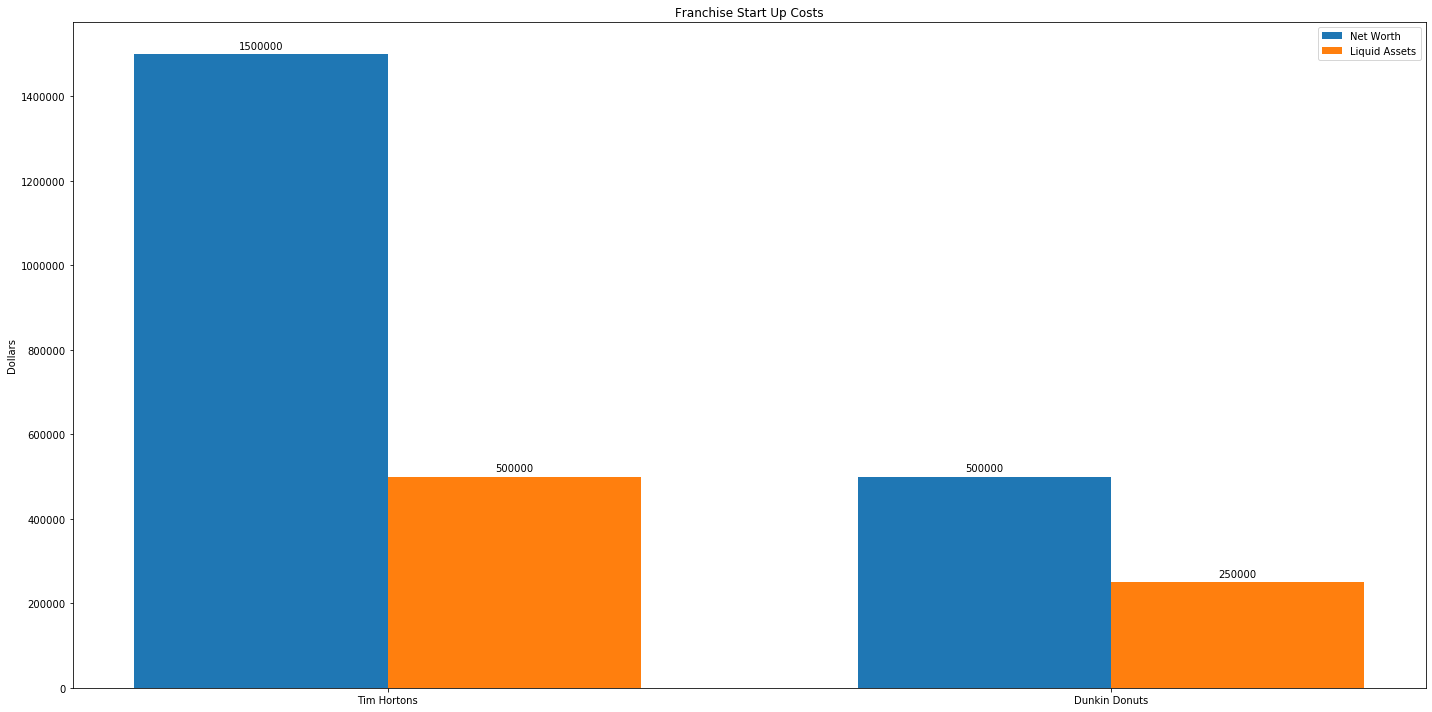

In [100]:
# Tim Horton franchise data taken from https://company.timhortons.com/us/en/corporate/franchising-frequently-asked-questions.php
# Dunkin Donut franchise data taken from https://www.findafranchise.com/franchise/dunkin-donuts?utm_source=google&utm_medium=cpc&utm_term=dunkin%27%2Bdonuts%2Bfranchise%2Fexact&utm_campaign=franchise-brands-faf&gclid=Cj0KCQjw4dr0BRCxARIsAKUNjWQKQnNYRLfYAuPz1WLi3oLLLVFIjLTS3-0wv4J1kgAHzIxPbIbpgNwaAhMiEALw_wcB

labels = ['Tim Hortons', 'Dunkin Donuts']
Net_Worth = [1500000, 500000]
Liquid_Assets = [500000, 250000]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(20,10))
rects1 = ax.bar(x - width/2, Net_Worth, width, label='Net Worth')
rects2 = ax.bar(x + width/2, Liquid_Assets, width, label='Liquid Assets')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Dollars')
ax.set_title('Franchise Start Up Costs')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

Starbucks does not sell franchises and neither does Preet's Coffee.  Two national brands that do sell franchises are Tim Hortons and Dunkin Donuts.  Based on the franchise start up costs it is significantly cheaper to start a Dunkin Donuts.

## Discussion

- Even though there were only 3 cities in the top 100 list of best cities for coffee lovers, the cities from the North West scored high on the list, and Seattle was at the top.
- Both Bellingham and Vancouver Washington have 7 coffee shops listed in Foursquare when using a radius of 1000.   
- The majority of the coffee shops appear to be small local independent coffee shops.  
- The only national brand of coffee shop found was Starbucks.  Vancouver has two, and Bellingham only has 1.
- In both cities the coffee shops appear to be very concentrated in the central downtown area of the city in close proximity to each other. 
- Vancouver, WA has a significantly larger population in the surrounding metro area.
- Dunkin Donuts franchise costs are considerably lower than Tim Hortons.

### Recommendations
- Given the fact that the state of Washignton had the top city for coffee lovers, but there were only 3 cities on the list for the region, suggests that there is still untapped demand for great coffee in the region.
- Based on the data from Foursquare, neither Bellingham or Vancouver Washington appear to be overly saturated with coffee shops and could probably support a new venue.  
- Given the fact that the coffee shops in both cities appear to be located in relatively close proximity to each other, it may be advisable to select a location away from the other coffee shops and closer to colleges, and suburban shopping centers.  
- When looking at the population data for the surrounding metro area, it seems clear that Vancouver is likely the best choice for a new Coffee Shop.
- If start up cost is an issue then Dunkin Donuts may be a good choice for a franchise.

## Conclusions

In Conclusion, based on the data that was examined in this report it seems clear that a new coffee shop could be a profitable investment.  Of the two cities, Vancouver, WA looks like the preferable city.  Of the franchises looked at, Dunkin Donuts is the cheapest with respect to Net Worth and Liquid Assets required.

### Caveats
The conclusions arrived at in this notebook are based on Foursquare data should be taken with some caution since Foursquare does not contain an exhaustive list of venues in a particular city.  This can be demonstrated with a quick Google search for coffee shops in Vancouver and Bellingham area.  Such a search will return a larger total number of coffee shops in those cities than was returned by Foursquare. 

A google maps image of coffee shops in Bellingham, Washington.

<img src="bellingham_wa_coffee_shops_google.png">

A google maps image of coffee shops in Vancouver, Washington.

<img src="vancouver_wa_coffee_shops_google.png">

### Acknowledgements
The data analysis methods and python code used in this notebook borrows heavily from code patterns that are covered in the lesson modules for the various badges that are covered as part of the IBM Data Science Certificate program.  In addition to these lesson modules there is a wealth of data online on how to create python data analysis and visualizations.  I have noted many of these valuable resources in my code comments.

### Disclaimer
I am not a financial advisor and have no formal training in investment consultation.  This analysis was done as part of the IBM Data Science Certificate program and was done for purely academic reasons as part of the capstone project.  Further market analysis should be done to truly evaluate the viability of a coffee shop in these cities. 